In [13]:
%load_ext autoreload

In [14]:
%autoreload 2

In [15]:
from spectral import *
import numpy as np
import scipy.spatial.distance as distance
import pylab
import spectral.io.envi as envi
import random
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from timeit import default_timer as timer

In [16]:
from autoclustering import find_maxdist_clusters
from hiersubclustering import subdivide_by_modules
from visual_utils import show_classes, show_histogram, show_centers
from math_utils import cluster_histogram, normalized

Читаем изображение.

In [17]:
img = aviris.open('f970619t01p02_r02_sc04.a.rfl', 'f970619t01p02_r02.a.spc')

	Data Source:   '/home/marko/HSI/f970619t01p02r02c/f970619t01p02_r02_sc04.a.rfl'
	# Rows:            512
	# Samples:         614
	# Bands:           224
	Interleave:        BIP
	Quantization:  16 bits
	Data format:     int16
float64


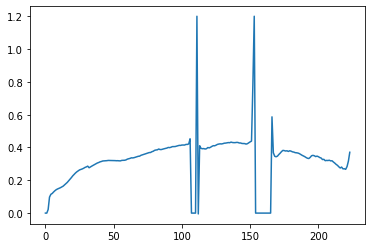

In [18]:
print(img)
print(img[380, 496].dtype)
pylab.plot(img[380, 496])

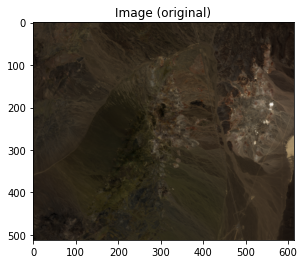

In [19]:
view = imshow(img, (29, 20, 12), title="Image (original)")

Число каналов:  224
Минимальная длина волн:  369.85
Максимальная длина волн:  2506.81


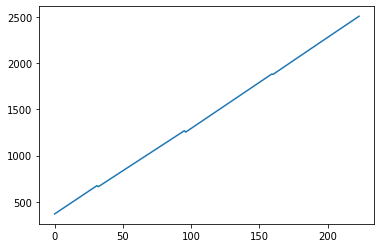

In [21]:
wavelengths_original = np.array(img.bands.centers)
print('Число каналов: ', len(wavelengths_original))
print('Минимальная длина волн: ', min(wavelengths_original))
print('Максимальная длина волн: ', max(wavelengths_original))
pylab.plot(wavelengths_original)

Видно что на трёх местах длина волн не возрастает монотонно. В частности, на 32ом элементе падает.

In [22]:
print(wavelengths_original[28:38])

[645.96 655.84 665.73 675.62 664.14 673.72 683.3  692.88 702.46 712.04]


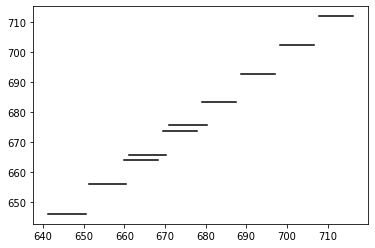

In [23]:
local_wl_centers = np.array(img.bands.centers[28:38])
local_bandwidths = np.array(img.bands.bandwidths[28:38])
band_starts = local_wl_centers - local_bandwidths / 2
band_ends = local_wl_centers + local_bandwidths / 2

pylab.figure()
for (c, s, e) in zip(local_wl_centers, band_starts, band_ends):
    pylab.plot([s, e], [c, c], color='black')

pylab.show()

Кроме того что они не в возрастающем порядке, они также значительно пересекаются. Отсортируем их.

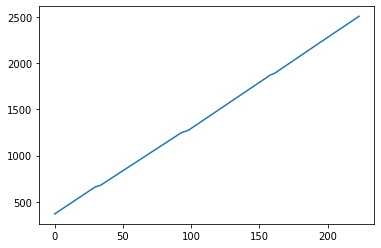

In [24]:
wavelengths_sorted = np.sort(wavelengths_original)
pylab.plot(wavelengths_sorted)

In [25]:
print(img[380, 496])
some_spectrum = img[380, 496].astype(float)
resampler = BandResampler(wavelengths_original, wavelengths_sorted, img.bands.bandwidths)
some_spectrum_resampled = resampler(some_spectrum)

[ 0.      0.      0.0218  0.0975  0.1146  0.1199  0.1288  0.1367  0.1431
  0.1475  0.151   0.1548  0.1594  0.1643  0.1719  0.179   0.187   0.1966
  0.2057  0.2161  0.2268  0.2354  0.2442  0.2515  0.2574  0.2632  0.266
  0.2693  0.2733  0.2784  0.2817  0.2862  0.2764  0.2816  0.2866  0.2912
  0.2956  0.3007  0.3052  0.3082  0.3123  0.3146  0.3177  0.3181  0.319
  0.3196  0.321   0.3209  0.3209  0.3211  0.3205  0.3199  0.3192  0.3195
  0.3186  0.3185  0.3214  0.3218  0.3221  0.3241  0.3289  0.3312  0.3335
  0.337   0.3363  0.338   0.3406  0.3439  0.3462  0.3471  0.3523  0.3552
  0.3586  0.3604  0.3631  0.3651  0.3689  0.3694  0.3742  0.377   0.3825
  0.3847  0.3857  0.3906  0.3873  0.3875  0.3902  0.3923  0.3944  0.3964
  0.4002  0.3991  0.4015  0.4052  0.4055  0.4056  0.4079  0.4102  0.4128
  0.4126  0.4149  0.4147  0.4149  0.4187  0.4186  0.4217  0.4529  0.
  0.      0.      0.      1.2    -0.005   0.4105  0.3946  0.3924  0.3932
  0.3907  0.3924  0.3998  0.3974  0.4015  0.4068  0.4109 

Посмотрим как выглядят графики, оригинальный, с отсортированными длинами волн, и с отсортированными длинами волн и соответствующей корректировкой измерений.

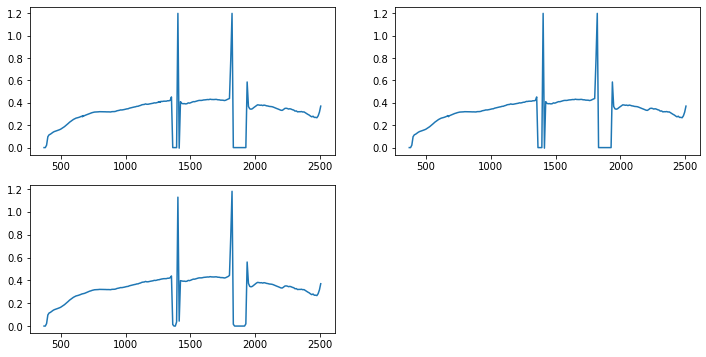

In [26]:
fig = pylab.figure()
fig.set_size_inches(3*4, 1*6)
pylab.subplot(2, 2, 1)
pylab.plot(wavelengths_original, some_spectrum)
pylab.subplot(2, 2, 2)
pylab.plot(wavelengths_sorted, some_spectrum)
pylab.subplot(2, 2, 3)
pylab.plot(wavelengths_sorted, some_spectrum_resampled)
pylab.show()

Посмотрим часть которая нам была интересной сначала.

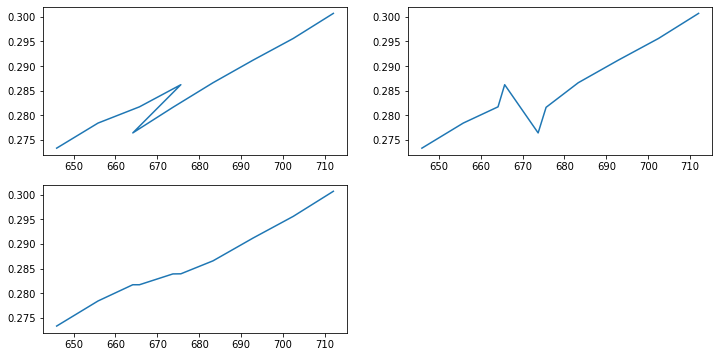

In [27]:
fig = pylab.figure()
fig.set_size_inches(3*4, 1*6)
pylab.subplot(2, 2, 1)
pylab.plot(wavelengths_original[28:38], some_spectrum[28:38])
pylab.subplot(2, 2, 2)
pylab.plot(wavelengths_sorted[28:38], some_spectrum[28:38])
pylab.subplot(2, 2, 3)
pylab.plot(wavelengths_sorted[28:38], some_spectrum_resampled[28:38])
pylab.show()

Видно что сортировка помогла. Посмотрим ещё одну интересную часть.

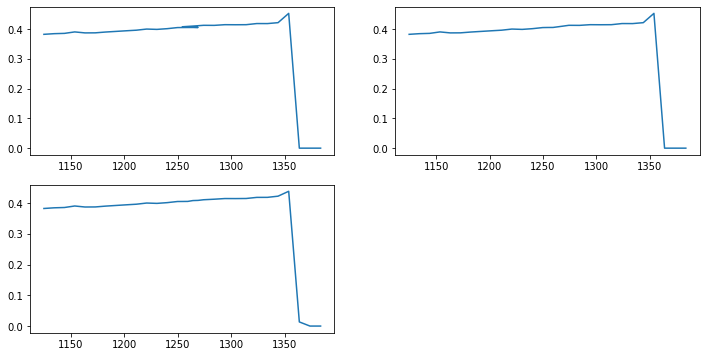

In [29]:
fig = pylab.figure()
fig.set_size_inches(3*4, 1*6)
pylab.subplot(2, 2, 1)
pylab.plot(wavelengths_original[80:110], some_spectrum[80:110])
pylab.subplot(2, 2, 2)
pylab.plot(wavelengths_sorted[80:110], some_spectrum[80:110])
pylab.subplot(2, 2, 3)
pylab.plot(wavelengths_sorted[80:110], some_spectrum_resampled[80:110])
pylab.show()

Тут ещё видно что нам нужно ещё и значения скорректировать. Поэтому, исправим целое изображение.

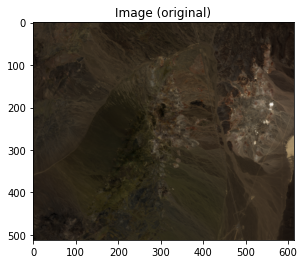

In [31]:
view = imshow(img, (29, 20, 12), title="Image (original)")

In [32]:
data = img[:,:,:]
#data = img[400:1000, 200:, :]
#data = img[400:700, 200:400, :]

In [33]:
data[data < 0] = 0
print(data.dtype)

float64


In [39]:
data[:, :, 106:115] = 0
data[:, :, 148:169] = 0

In [40]:
img_width = data.shape[0]
img_height = data.shape[1]
img_depth = data.shape[2]
data = np.dot(data.reshape(img_width*img_height, img_depth), resampler.matrix.T)
data = data.reshape(img_width, img_height, img_depth)

In [41]:
wavelengths = wavelengths_sorted
wavelengths_um = wavelengths / 1000

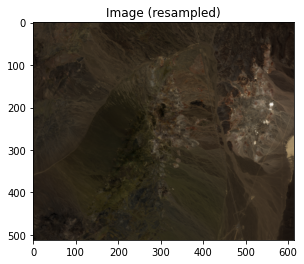

In [42]:
view = imshow(data, (29, 20, 12), title="Image (resampled)")

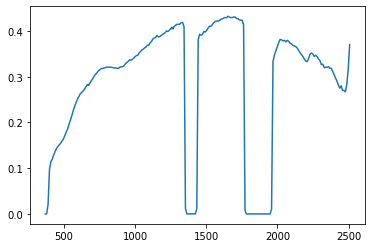

In [45]:
some_spectrum = data[380, 496]
pylab.plot(wavelengths_original, some_spectrum)

Будем проверять работу алгоритмов используя несколько ~~интересных сигнатур.~~

1. ~~Травы~~
2. ~~Асфальта~~
3. ~~Морской воды~~
4. ~~Бетона~~

Надо упомянуть что особенно травы и воды могут быть разные. Вода может быть в большей или меньшей степени загрязненной, трава свежей или сухой, итд. Все ниже выбранные сигнатуры находятся около самого аэродрома.

In [56]:
interesting_spectra = [data[123, 423].astype(float),
                          data[143, 443].astype(float),
                          data[383, 612].astype(float),
                          data[95, 143].astype(float),
                         ]
interesting_colors = ['green', 'darkgrey', 'blue', 'lightgrey']
interesting_continuum_colors =  ['lightgreen', 'grey', 'lightblue', 'yellow']

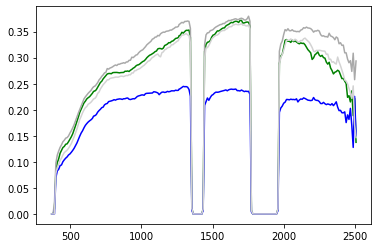

In [57]:
from visual_utils import draw_ontop
draw_ontop(interesting_spectra, wavelengths, interesting_colors)

Проверим работу функции удаления континуума написанных на С.

Проверим работу функции удаления континуума на питоне.

In [58]:
from utils import filter_out_invalid_spectra
from spectral.algorithms.continuum import remove_continuum
spectra = filter_out_invalid_spectra(data)

In [ ]:
avg = np.average(spectra, axis=0)
cr_avg = remove_continuum(avg, wavelengths)

In [74]:
maxes = np.max(spectra, axis=0)
cr_maxes = remove_continuum(maxes, wavelengths)

In [75]:
from math_utils import find_max_diff_l2
max_diff_l2 = find_max_diff_l2(spectra, avg)
cr_max_diff_l2 = remove_continuum(max_diff_l2, wavelengths)

In [76]:
from math_utils import find_max_diff_l1
max_diff_l1 = find_max_diff_l1(spectra, avg)
cr_max_diff_l1 = remove_continuum(max_diff_l1, wavelengths)

In [77]:
from math_utils import find_max_diff_angle
max_diff_angle = find_max_diff_angle(spectra, avg)
cr_max_diff_angle = remove_continuum(max_diff_angle, wavelengths)

In [78]:
from math_utils import find_with_max_norm2
max_norm2 = find_with_max_norm2(spectra)
cr_max_norm2 = remove_continuum(max_norm2, wavelengths)

In [79]:
from math_utils import find_with_max_norm1
max_norm1 = find_with_max_norm1(spectra)
cr_max_norm1 = remove_continuum(max_norm1, wavelengths)

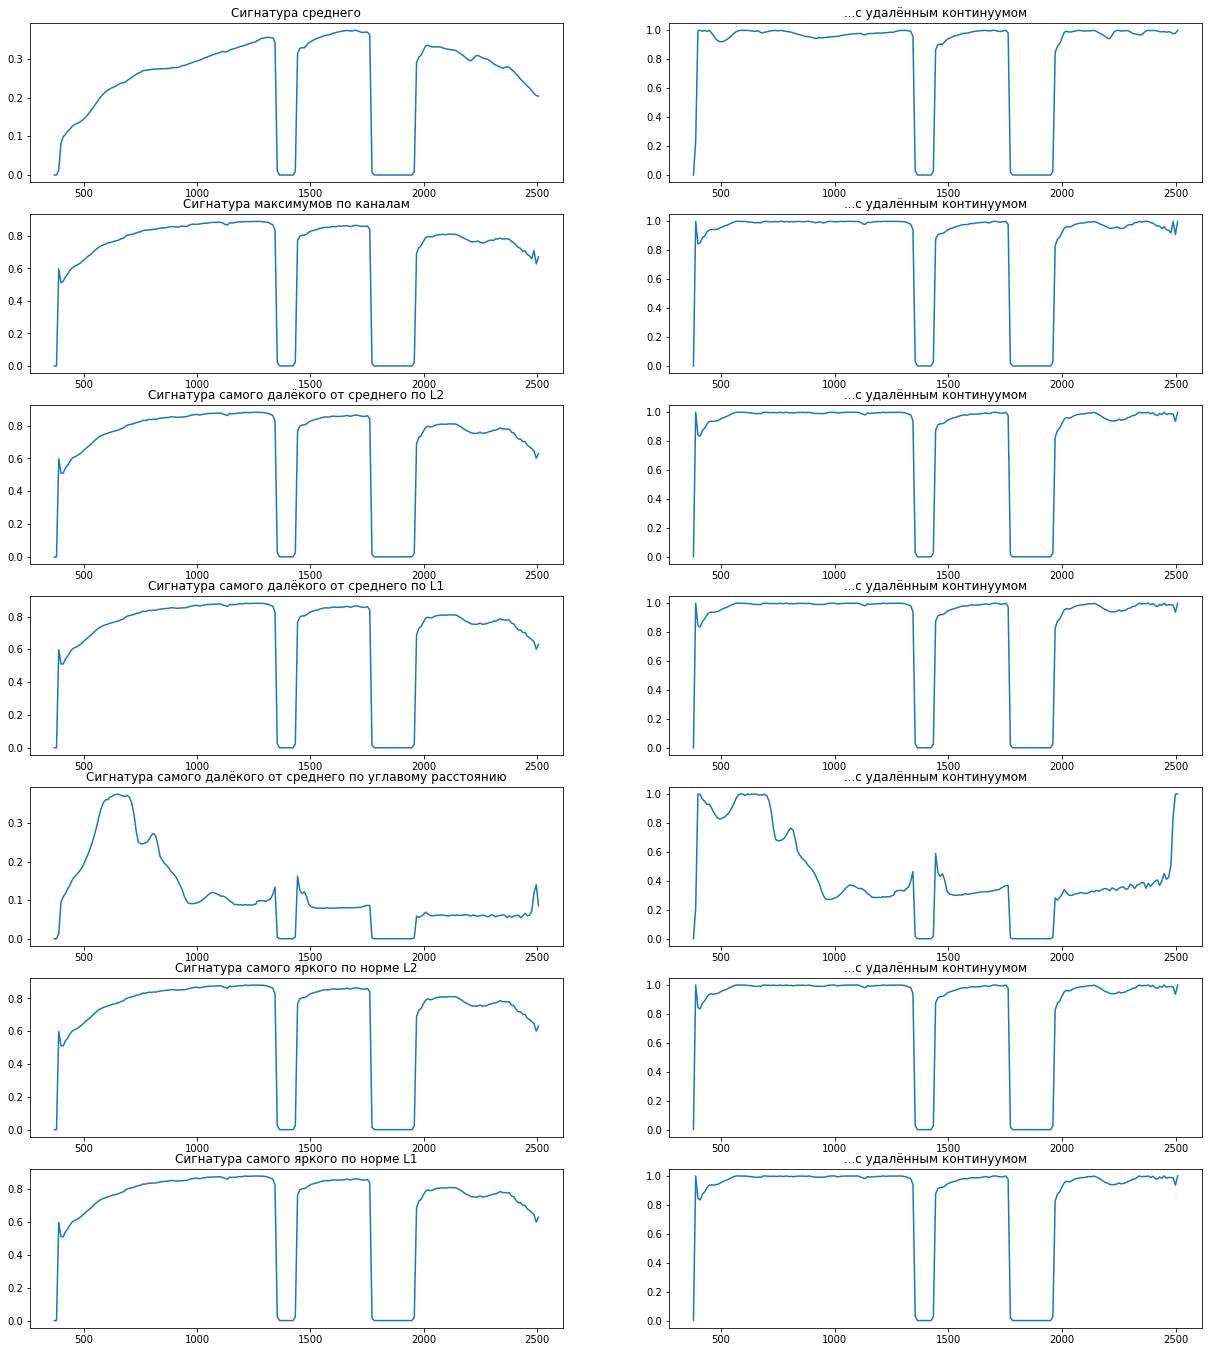

In [80]:
figs = [
    {
     'title': 'Сигнатура среднего',
     'sig': avg,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_avg
    },
    {
     'title': 'Сигнатура максимумов по каналам',
     'sig': maxes,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_maxes
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по L2',
     'sig': max_diff_l2,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_diff_l2
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по L1',
     'sig': max_diff_l1,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_diff_l1
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по углавому расстоянию',
     'sig': max_diff_angle,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_diff_angle
    },
    {
     'title': 'Сигнатура самого яркого по норме L2',
     'sig': max_norm2,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_norm2
    },
    {
     'title': 'Сигнатура самого яркого по норме L1',
     'sig': max_norm1,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_norm1
    }
]


fig = pylab.figure()
fig.set_size_inches(len(figs)*3, 2*12)

for i in range(len(figs)):
    ax = pylab.subplot(len(figs), 2, (i*2)+1)
    ax.set_title(figs[i]['title'])
    pylab.plot(wavelengths, figs[i]['sig'])
    ax = pylab.subplot(len(figs), 2, (i*2)+2)
    ax.set_title(figs[i]['cr-title'])
    pylab.plot(wavelengths, figs[i]['cr-sig'])

pylab.show()

Посмотрим где находится самая отличающаяся сигнатура.

In [81]:
from utils import find_image_coords_of_spectrum
coords = find_image_coords_of_spectrum(data, max_diff_l2)
print(coords)

(193, 560)


In [82]:
from spectral.database import USGSDatabase
usgs = USGSDatabase('full_usgs.db')

In [83]:
for s in USGSDatabase.schemas:
    print(s)

CREATE TABLE Samples (SampleID INTEGER PRIMARY KEY, LibName TEXT, Record INTEGER, Description TEXT, Spectrometer TEXT, Purity TEXT, MeasurementType TEXT, Chapter TEXT, FileName TEXT, AssumedWLSpmeterDataID INTEGER, NumValues INTEGER, MinValue FLOAT, MaxValue FLOAT, ValuesArray BLOB)
CREATE TABLE SpectrometerData (SpectrometerDataID INTEGER PRIMARY KEY, LibName TEXT, Record INTEGER, MeasurementType TEXT, Unit TEXT, Name TEXT, Description TEXT, FileName TEXT, NumValues INTEGER, MinValue FLOAT, MaxValue FLOAT, ValuesArray BLOB)


In [84]:
usgs.print_query('SELECT DISTINCT Chapter FROM Samples')

ChapterS_SoilsAndMixtures
ChapterL_Liquids
ChapterV_Vegetation
ChapterA_ArtificialMaterials
ChapterC_Coatings
ChapterM_Minerals
ChapterO_OrganicCompounds


In [85]:
usgs.print_query('SELECT DISTINCT Purity FROM Samples')

b
a
c
bc
ccc
bbb
aa
bb
bbu
aaa
cc
aau
ccu
cb
d
cbb
cd
u
cbu
buu
bcu
uu
bcb
bcc
cdb
dbb
dcc
ddd
cbc
cdu
cdd
dd


In [86]:
usgs.print_query('SELECT DISTINCT LibName FROM Samples')

s07_AV05
s07_VIMS
s07_HY14
s07_AV11
s07_AV13
s07_AV12
splib07a
s07HYPRN
s07_AV97
S07LSAT8
s07CRSMg
s07_ASD
s07_AV14
splib07b
s07_AV99
s07_AV10
s07CRSMj
s07_HY07
S07ASTER
s07_AV98
s07_AV96
S07SNTL2
s07_M3t
S07WV3
s07_AV95
s07_AV06
s07_AV00
s07_AV09
s07_AV01


In [101]:
usgs.print_query('SELECT DISTINCT Purity FROM Samples WHERE LibName == \'s07_AV97\'')

b
a
bc
aaa
bbb
c
bb
ccc
bbu
aa
cc
aau
cd
cbb
bcu
cbu
ccu
cb
dd
d
bcb
cdd
uu
bcc
buu
u
dbb
cdu
ddd
dcc
cdb
cbc


In [102]:
usgs.print_query('SELECT SampleID, Description FROM Samples WHERE LibName = \'s07_AV97\' AND Chapter = \'ChapterM_Minerals\' AND Description LIKE \'Alunite%\' ')

20503|Alunite GDS83 Na63 NIC4bb RREF
20525|Alunite GDS82 Na82 NIC4bc RREF
20535|Alunite HS295 ASDFRa AREF
20573|Alunite SUSTDA-20 NIC4bb RREF
20621|Alunite GDS83 Na63 BECKb AREF
20645|Alunite RES-3 Na Syn (450C) NIC4a RREF
20733|Alunite HS295.6 ASDFRb AREF
20748|Alunite RES-9 Summitv (400C) ASDNGb AREF
20820|Alunite HS295.1B ASDFRa AREF
20831|Alunite HS295.3B NIC4aaa RREF
20890|Alunite RES10 NA56% Syn 450C NIC4a RREF
20896|Alunite RES12 NA78% Syn 450C NIC4a RREF
21001|Alunite GDS97 K Syn (150C) NIC4a RREF
21032|Alunite GDS83 Na63 NIC4b RREF
21086|Alunite AL706 Na100 BECKb AREF
21098|Alunite SUSTDA-20 BECKb AREF
21120|Alunite GDS84 Na03 NIC4a RREF
21142|Alunite GDS95 Na Syn (150C) NIC4a RREF
21168|Alunite GDS96 K Syn (250C) NIC4a RREF
21224|Alunite HS295.3B ASDNGa AREF
21242|Alunite HS295.3B BECKa AREF
21258|Alunite RES-9 Summitv (400C) NIC4b RREF
21283|Alunite RES-2 K Syn (450C) NIC4a RREF
21292|Alunite HS295.4B ASDFRa AREF
21359|Alunite GDS84 Na03 NIC4aa RREF
21452|Alunite HS295.3B AS

In [103]:
alunite_ids = [r[0] for r in usgs.query('SELECT SampleID, Description FROM Samples WHERE LibName = \'s07_AV97\' AND Chapter = \'ChapterM_Minerals\' AND Description LIKE \'Alunite%\' ')]
print(alunite_ids)
print(len(alunite_ids))

[20503, 20525, 20535, 20573, 20621, 20645, 20733, 20748, 20820, 20831, 20890, 20896, 21001, 21032, 21086, 21098, 21120, 21142, 21168, 21224, 21242, 21258, 21283, 21292, 21359, 21452, 21552, 21573, 21590, 21635]
30


In [136]:
specs = [usgs.get_spectrum(id) for id in alunite_ids]

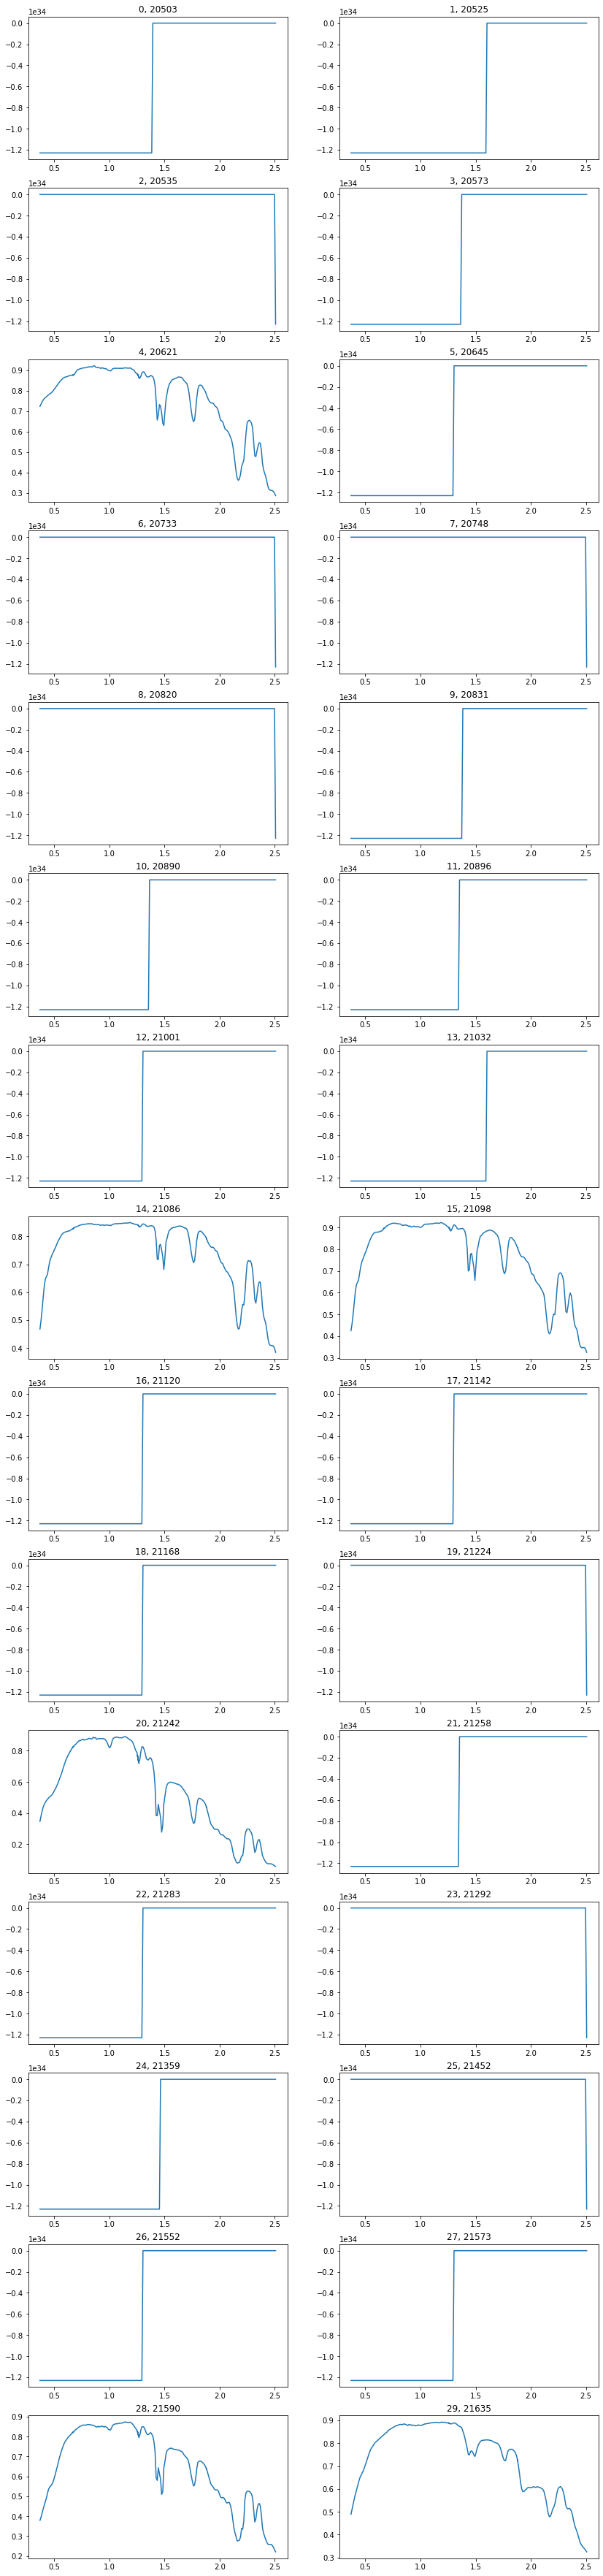

In [137]:
fig = pylab.figure()
fig.set_size_inches(14, 64)

for i, id in enumerate(alunite_ids):
    pylab.subplot(len(alunite_ids) // 2, 2, i + 1)
    x, y = specs[i]
    pylab.plot(x, y)
    pylab.title(str(i) + ', ' + str(id))

pylab.show()

In [135]:
usgs.print_query('SELECT LibName, Chapter, FileName FROM Samples WHERE SampleID == 20503')

s07_AV97|ChapterM_Minerals|s07_AV97_Alunite_GDS83_Na63_NIC4bb_RREF.txt


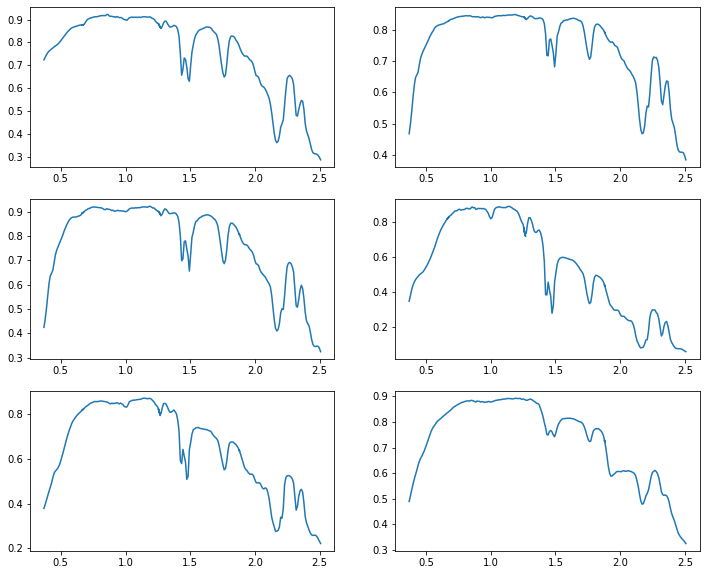

In [138]:
good_alunites = [specs[i] for i in [4, 14, 15, 20, 28, 29]]
fig = pylab.figure()
fig.set_size_inches(12, 10)

for i, (x, y) in enumerate(good_alunites):
    pylab.subplot(len(good_alunites) // 2, 2, i + 1)
    pylab.plot(x, y)

pylab.show()

In [143]:
alunite_refls = np.array([y for x, y in good_alunites])
wavelengths = good_alunites[0][0]
alunite_refls.shape

(6, 224)

In [155]:
alunite = np.average(alunite_refls, axis=0)

In [156]:
alunite.shape

(224,)

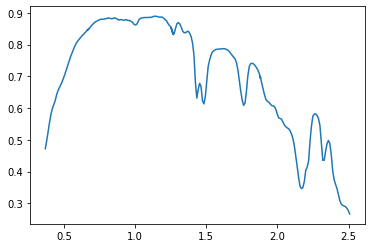

In [157]:
pylab.plot(wavelengths, alunite)

In [158]:
alunite_matrix = alunite[np.newaxis]
alunite_matrix.shape

(1, 224)

In [213]:
from spectral.algorithms import spectral_angles
angles = spectral_angles(data, alunite_matrix)

ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.38030003442281396, 0.6450570056827927]
    G: [0.38030003442281396, 0.6450570056827927]
    B: [0.38030003442281396, 0.6450570056827927]

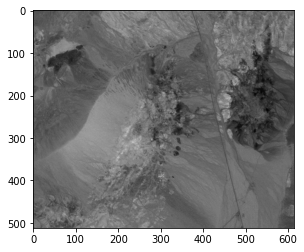

In [214]:
imshow(angles)

In [225]:
from spectral.algorithms import remove_continuum
data_nn = data.copy()
data_nn[data_nn == 0.0] = 0.01
data_cr = remove_continuum(data_nn, np.array(wavelengths), mode='segmented')

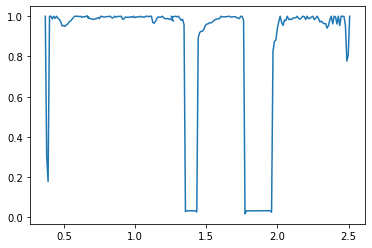

In [226]:
pylab.plot(wavelengths, data_cr[12, 43])

In [227]:
alunite_matrix_cr = remove_continuum(alunite_matrix, np.array(wavelengths), mode='segmented')

In [228]:
data_cr[data_cr == 0.0] = 0.1

In [229]:
np.sum(data_cr == 0.0)

0

In [230]:
angles_cr = spectral_angles(data_cr, alunite_matrix_cr)

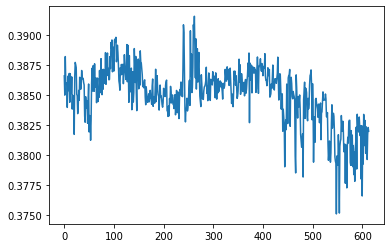

In [231]:
pylab.plot(range(angles_cr.shape[1]), angles_cr[0].squeeze())

In [232]:
alunite_matrix_cr

array([[1.        , 0.99463204, 0.99715627, 1.        , 1.        ,
        1.        , 0.99660408, 0.99419651, 1.        , 1.        ,
        0.99610971, 0.99167512, 0.98927904, 0.98973179, 0.99026077,
        0.9928445 , 0.99600675, 0.99853716, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99994151, 1.        , 0.99986534, 0.99960325, 0.99973066,
        1.        , 0.99861026, 1.        , 0.99845905, 0.99933125,
        0.999822  , 1.        , 1.        , 1.        , 1.        ,
        0.99976091, 1.        , 1.        , 0.99884049, 0.99880458,
        0.99869676, 0.99923401, 1.        , 1.        , 0.99855523,
        0.99699685, 0.99789416, 1.        , 0.9976331 , 0.99564515,
        0.99177953, 0.9931716 , 0.99301428, 0.992211  , 0.99066826,
        0.99272569, 0.9923007 , 0.98944626, 0.99034031, 0.98689039,
        0.98410605, 0.97762334, 0.97385957, 0.97491076, 0.9830177 ,
        0.99342229, 0.99674609, 0.99883424, 0.99

ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.3668373719037468, 0.549569638806513]
    G: [0.3668373719037468, 0.549569638806513]
    B: [0.3668373719037468, 0.549569638806513]

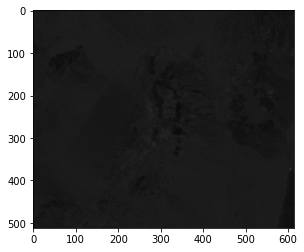

In [233]:
imshow(angles_cr)

In [224]:
angles[0, 0]

array([0.46049254])

In [211]:
angles_cr[0, 0, 0]

nan

In [192]:
import spectral.io.envi as envi
splib = envi.open('full_usgs_envi_aviris.hdr', 'full_usgs_envi_aviris.sli')

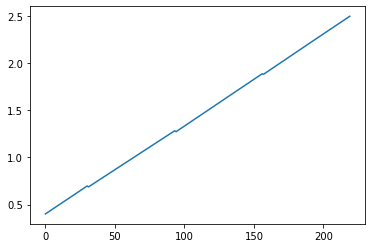

In [200]:
pylab.plot(splib.bands.centers)

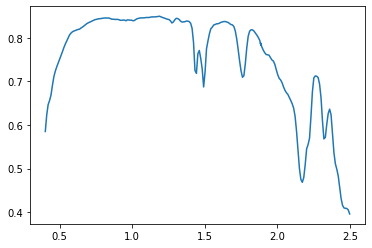

In [201]:
pylab.plot(splib.bands.centers, splib.spectra[splib.names.index("b'Alunite AL706 Na100 BECKb AREF'")])
#splib.names.index("b'Zincite+Franklin HS147.2B ASDFRb AREF'")